# 4.1장

<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2024-2/blob/main/ML_day0/0_3_KNN_LR_LS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy
from scipy import linalg
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn import linear_model

data_path_url = 'https://raw.githubusercontent.com/SLCFLAB/Fintech2025/main/ML_day4/data/'

# 1. KNN & Linear Regression

https://github.com/songsuoyuan/The-Element-of-Statistical-Learning-Python-Implements

In [22]:
import numpy as np
from sklearn import linear_model
from sklearn import neighbors
from scipy.stats import multivariate_normal

In [24]:
data = np.loadtxt(data_path_url + 'mixture_simulation_data.txt', skiprows=1)
means = np.loadtxt(data_path_url + 'means.txt')
X = data[:,:2]
y = data[:,2]

In [26]:
def linear_regression(X, y):
    '''
    Linear regression model:
        y = w_0 + w_1 * x_1 + ... + w_p * x_p
        coef_ = (w_1, ..., w_p), intercept_ = w_0
    Solution:
        solve min |X_ * w - y|^2
    where X_ = [ones, X]
    Complexity: O(np^2), based on SVD
    '''

    clf = linear_model.LinearRegression()
    clf.fit(X, y)

    line = lambda x: ((0.5 - clf.intercept_ - clf.coef_[0] * x) / clf.coef_[1])
    line_x = [min(X[:,0]) - 0.2, max(X[:,0] + 0.5)]
    line_y = list(map(line, line_x))

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(X[:,0], X[:,1], c=y, alpha=.6)
    plt.plot(line_x, line_y, color='b', alpha=.8, linewidth=3)
    plt.xlim([-3, 5])
    plt.ylim([-3, 5])
    plt.show()

    print('(beta_0) = ' + str(clf.intercept_))
    print('(beta_1, beta_2) = ' + str(clf.coef_))
    print('Precision:', 100. * sum(list(map(round, clf.predict(X))) == y) / len(y))

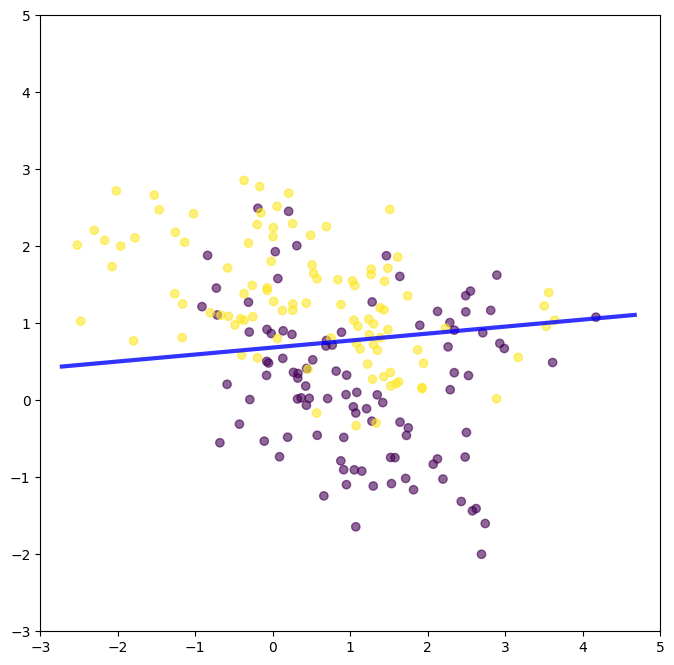

(beta_0) = 0.3290614021555317
(beta_1, beta_2) = [-0.022636    0.24959834]
Precision: 73.0


In [27]:
linear_regression(X, y)

In [28]:
def k_nearest_neighbor(X, y, k):
    '''
    K nearest neighbor method:
        y(x) = 1 / k * (y_1 + ... + y_k)
    where y_i belongs to the k closest points to the point x
    Complexity: based on implement, brute force is O(Dn^2)
    '''
    
    clf = neighbors.KNeighborsRegressor(n_neighbors=k)
    clf.fit(X, y)

    delta = .1
    grid_x = np.arange(min(X[:,0]) - 0.5, max(X[:,0]) + 0.5, delta)
    grid_y = np.arange(min(X[:,1]) - 0.5, max(X[:,1]) + 0.5, delta)
    grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
    combine_XY = np.dstack((grid_X, grid_Y)).reshape(grid_X.size, 2)
    Z = clf.predict(combine_XY)
    grid_Z = Z.reshape(grid_X.shape)

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(X[:,0], X[:,1], c=y, alpha=.6)
    plt.contour(grid_X, grid_Y, grid_Z, 1, alpha=.8,
                colors='b', linewidths=3)
    plt.show()

    print('Precision:', 100. * sum(list(map(round, clf.predict(X))) == y) / len(y))

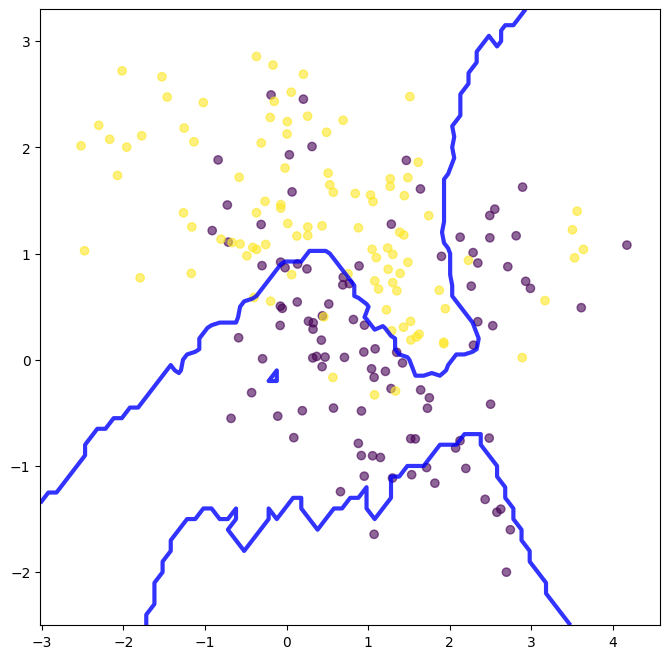

Precision: 84.5


In [31]:
k_nearest_neighbor(X, y, 15)

In [34]:
def optimal_bayes(X, y, means):
    '''
    First 10 means m_k are generated from bivariate Gaussian
    N([0,1],I) and labeled as RED, another 10 means are generated
    from N([1,0],I) and labeled as BLUE. Then 100 RED observations
    are generated by first pick an m_k at random with p=0.1, then
    generate observation by N(m_k,I/5). Another 100 BLUE
    observations are generated by the same procedure.
    Optimal Bayes decision attribute G(x) = k-th class where
    P(Y in k-th class | X = x) is the maximum.
    Estimated runtime = 25s
    '''

    delta = 0.1
    grid_x = np.arange(min(X[:, 0]) - 0.5, max(X[:, 0]) + 0.5, delta)
    grid_y = np.arange(min(X[:, 1]) - 0.5, max(X[:, 1]) + 0.5, delta)
    grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
    combine_XY = np.dstack((grid_X, grid_Y)).reshape(grid_X.size, 2)
    Z = []

    for p in combine_XY:
        dist_B = .0
        dist_R = .0
        covar  = [[0.2, 0], [0, 0.2]]
        for m in means[:10, :]:
            dist_B += multivariate_normal.pdf(p, mean=m, cov=covar)
        for m in means[10:, :]:
            dist_R += multivariate_normal.pdf(p, mean=m, cov=covar)
        Z.append(np.exp(np.log(dist_B) - np.log(dist_R)) - 1.)
    Z = np.array(Z)
    grid_Z = Z.reshape(grid_X.shape)

    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.6)
    plt.scatter(means[:10, 0], means[:10, 1], s=80, color='blue')
    plt.scatter(means[10:, 0], means[10:, 1], s=80, color='red')
    plt.contour(grid_X, grid_Y, grid_Z, 1, alpha=.8,
                colors='b', linewidths=3)
    plt.show()

    n = len(y)
    predict = []
    for i in range(n):
        dist_B = 0.
        dist_R = 0.
        covar  = [[0.2, 0],[0, 0.2]]
        for m in means[:10,:]:
            dist_B += multivariate_normal.pdf(X[i, :], mean=m,
                                              cov=covar)
        for m in means[10:, :]:
            dist_R += multivariate_normal.pdf(X[i, :], mean=m,
                                              cov=covar)
        if (dist_B > dist_R):
            predict.append(0)
        else:
            predict.append(1)

    print(f'Precision:{100. * sum(predict == y) / len(y)}')

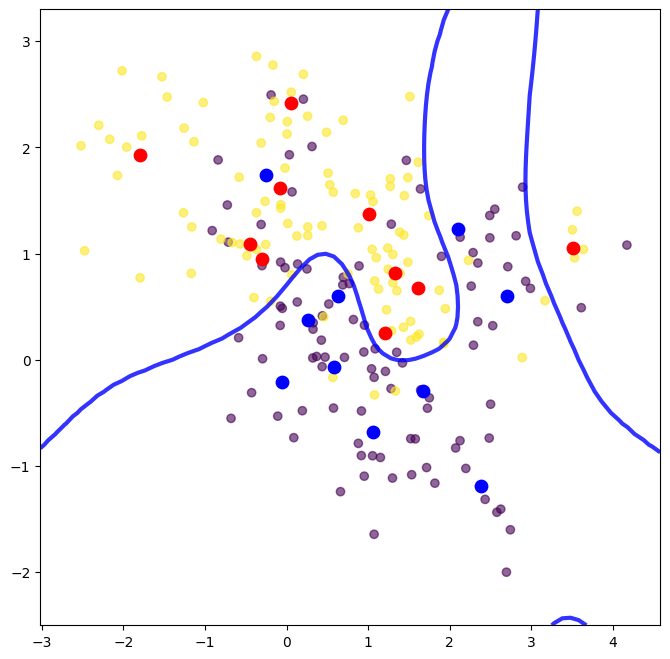

Precision: 85.0


In [35]:
optimal_bayes(X, y, means)